<h1 align = center> IMPACT OF NATURE OF CONTENT ON ONLINE HATE SPEECH DETECTION </h1>

<h1 align = center> LIBRAIRIES IMPORT </h1>

In [1]:
# !pip install matplotlib
# !pip install pandas 
# !pip install seaborn
# !pip install nltk
# !pip install scikit-learn
# # !pip install emoji
# !pip install wordcloud
# import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

In [2]:
#For data analysis
import numpy as np
import pandas as pd

#For data visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud

#For data preprocessing
import re
import string
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

#For evaluation metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

<h1 align=center> FUNCTIONS </h1>

In [3]:
#For Data pre processing
def decontracted(text):
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"ain\'t", "am not", text)
    text = re.sub(r"didnt",  "did not", text)
    text = re.sub(r"shan\'t", "shall not", text)
    text = re.sub(r"sha\'n\'t", "shall not", text)
    text = re.sub(r"let\'s", "let us", text)
    text = re.sub(r"o\'clock", "of the clock", text)
    #ultra specific
    text = re.sub(r"wont", "will not", text)
    text = re.sub(r"cant", "can not", text)
    text = re.sub(r"aint", "am not", text)
    text = re.sub(r"shant", "shall not", text)
    text = re.sub(r"ma\'am", "madam", text)
    text = re.sub(r"y\'all", "you all", text)
    # general
    text = re.sub(r"n\'y", " you", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text) 
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    filtered_output = [u for u in text if u not in stop_words]
    return filtered_output

def text_has_emoji(text):
    tmp = ''
    tmp_list = []
    for character in text:
        if character in emoji.EMOJI_DATA:
            tmp = emoji.replace_emoji(character, replace= emoji.demojize(character,language='en'))
        else:
            tmp = character
        tmp_list.append(tmp)
        final_output = " ".join(tmp_list)
    return final_output

def remove_punctuation(text):
    translator = str.maketrans("", "", string.punctuation)
    result = text.translate(translator)
    return result

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    output = []
    for word, tag in pos_tag(text.split()):
        if tag.startswith("NN"): #Noun
            output.append(lemmatizer.lemmatize(word,pos='n'))
        elif tag.startswith("VB"): #Verb
            output.append(lemmatizer.lemmatize(word,pos='v'))
        elif tag.startswith("JJ") | tag.startswith("VB") : #Adjective and adverb
            output.append(lemmatizer.lemmatize(word,pos='s'))
        else:
            output.append(lemmatizer.lemmatize(word))
    final_output = " ".join(output)
    return final_output

<h1 align ='center'> DATA UNDERSTANDING AND PREPARATION </h1>

In [4]:
#Read the dataset
df = pd.read_csv("Dynamically Generated Hate Dataset v0.2.3.csv")

In [5]:
#Get info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41144 entries, 0 to 41143
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      41144 non-null  int64 
 1   acl.id          41144 non-null  object
 2   X1              41144 non-null  int64 
 3   text            41144 non-null  object
 4   label           41144 non-null  object
 5   type            41144 non-null  object
 6   target          41136 non-null  object
 7   level           41144 non-null  object
 8   split           41144 non-null  object
 9   round.base      41144 non-null  int64 
 10  annotator       41144 non-null  object
 11  round           41144 non-null  object
 12  acl.id.matched  30098 non-null  object
dtypes: int64(3), object(10)
memory usage: 4.1+ MB


In [6]:
df.drop(columns='Unnamed: 0', inplace=True)

In [7]:
#Let's determine the null rows
#It appears that both "target" and "acl.id.matched" have null rows.
df.loc[df['target'].isnull()]

,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched
2220,acl12027,2256,I swear I will piss on this gross pikey until ...,hate,derogation,NaN,perturbation,train,2,vDe7GN0NrL,2b,acl12026
2741,acl12497,2777,Really? There are a lot of gypsy travellers th...,hate,derogation,NaN,perturbation,train,2,CAgNlUizNm,2b,acl12496
2971,acl12703,3007,alot ogf people make fun of my personality in ...,hate,support,NaN,perturbation,train,2,E3dsmnSPob,2b,acl12702
4175,acl13790,4214,"I have worse teeth than a camel humper, my mum...",hate,derogation,NaN,perturbation,train,2,QiOKkCi7F8,2b,acl13789
9093,acl18220,9137,Please stop inviting this squaw at the workplace,hate,derogation,NaN,perturbation,train,2,E3dsmnSPob,2b,acl18219
9185,acl18303,9229,A girl I'm working with hails from Egypt and t...,hate,derogation,NaN,perturbation,train,2,CAgNlUizNm,2b,acl18302
11812,acl20672,11861,fucking hell I've just seen a pikey,hate,derogation,NaN,perturbation,dev,2,GNZuCtwed3,2b,acl15469
23651,acl31350,23726,The purpose of the Aryan Hall is not just to h...,hate,support,NaN,original,train,4,iO6vHa6qJm,4a,acl31351


In [8]:
#For 2-class task and 5-class task, we are not focused on target column so we can keep all rows from this column 

In [9]:
df.loc[df['acl.id.matched'].isnull()]

,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched
0,acl1,1,dalits are lowlives,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
1,acl10,2,gay people are a burden to our society,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
2,acl100,3,Arabs are not welcome,hate,notgiven,notgiven,original,train,1,vDe7GN0NrL,1,NaN
3,acl1000,4,I'm not saying we should actually eliminate he...,hate,notgiven,notgiven,original,train,1,oemYWm1Tjg,1,NaN
4,acl10000,5,bananas are for black people,hate,notgiven,notgiven,original,test,1,QiOKkCi7F8,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
41135,acl9721,40948,I endorse the genocide of Muslims,hate,notgiven,notgiven,original,test,1,CAgNlUizNm,1,NaN
41136,acl9781,41014,Mandatory masks should be for mozzies only,hate,notgiven,notgiven,original,test,1,LqLKTtrOmx,1,NaN
41137,acl9790,41024,Women are dishonest,hate,notgiven,notgiven,original,test,1,CAgNlUizNm,1,NaN
41138,acl9867,41109,We must not fail to keep in mind that not all ...,nothate,none,none,original,test,1,CAgNlUizNm,1,NaN


In [10]:
#We can observe that all acl.id.matched non-null rows are from round 1, it's because round 1 doesn't contain perturbated data
#So acl.id.matched is not concerned by the removing process

In [11]:
#Get a view of the data
df.head()

,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched
0,acl1,1,dalits are lowlives,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
1,acl10,2,gay people are a burden to our society,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
2,acl100,3,Arabs are not welcome,hate,notgiven,notgiven,original,train,1,vDe7GN0NrL,1,NaN
3,acl1000,4,I'm not saying we should actually eliminate he...,hate,notgiven,notgiven,original,train,1,oemYWm1Tjg,1,NaN
4,acl10000,5,bananas are for black people,hate,notgiven,notgiven,original,test,1,QiOKkCi7F8,1,NaN


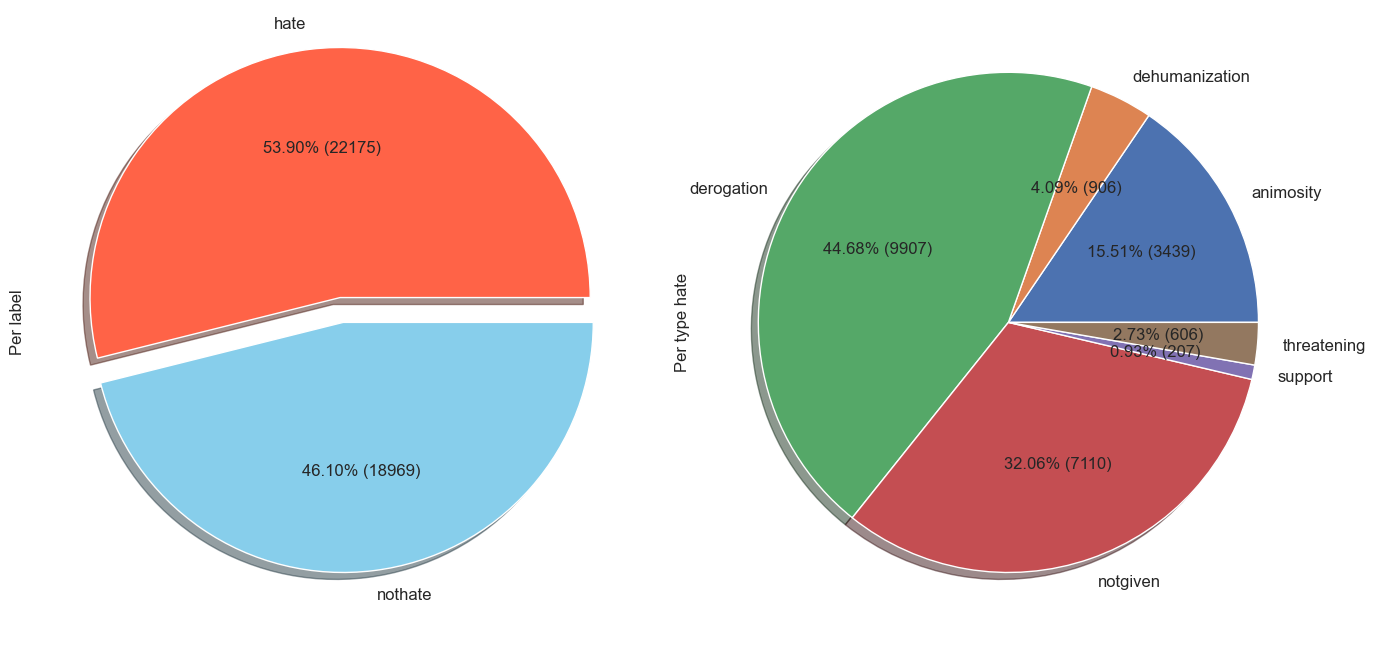

In [12]:
#Get the percentage of label and type hate
sns.set_theme()

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(18,8))
df.groupby('label').size().plot(kind='pie',
                                autopct=lambda p: '{:.2f}% ({:.0f})'.format(p,(p/100)*len(df)),
                                figsize=[14,14],
                                textprops={'fontsize': 12}, 
                                colors=['tomato', 'skyblue'],
                                explode=(0.1, 0),
                                shadow=True, 
                                startangle=0,
                                ax =ax1
                                )
# ax2 = plt.subplot(121)
df[df.label == 'hate'].groupby('type').size().plot(kind = 'pie',
                               autopct = lambda p :'{:.2f}% ({:.0f})'.format(p,(p/100)*len(df[df['label'] == 'hate'])),
                               figsize =[14,14],
                               textprops = {'fontsize': 12},
                               #explode=(0,0,0,0.1,0,0),
                               shadow= True,
                               startangle=0,
                               ax =ax2)
ax1.set_ylabel('Per label')
ax2.set_ylabel('Per type hate')                                     
plt.tight_layout()                                                                     
# plt.show()

In [13]:
#We will remove from hate dataset the rows with the type "notgiven" 
#However this rows could be used in Semi Supervised Learning approach for further researches in order to build robust classifiers

In [14]:
#Get the count of target items 
df[df['label']=='hate']['target'].value_counts()

target
notgiven                           7110
wom                                2035
bla                                1961
jew                                1096
mus                                1002
                                   ... 
wom, jew, mixed.race, non.white       1
mus, arab, non.white, asi.pak         1
gendermin, gay.wom, bis               1
mus, bla, immig, non.white            1
jew, mixed.race, gay                  1
Name: count, Length: 408, dtype: int64

In [15]:
len(df.target.dropna().unique())

409

In [16]:
#We count characters and word occurrences to establish a possible correlation between text length and no hate/ hate(type)
df['character_length'] = (df.text.str.len() - (df.text.str.split().str.len() - 1))
df['word_length'] = df.text.str.split().str.len()

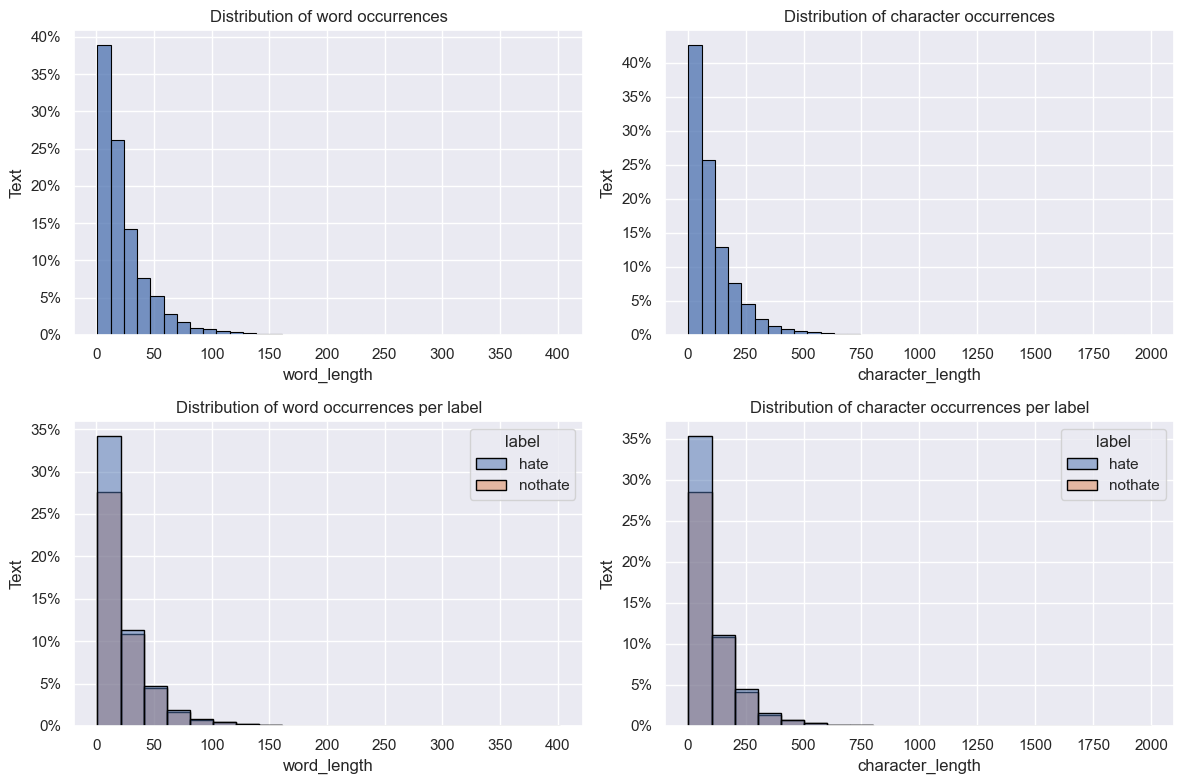

In [17]:
#Histplot of word and character occurrences 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
sns.histplot(data = df, x = 'word_length',ax = ax[0,0], weights=np.ones(len(df)) / len(df),  bins= 35,edgecolor='black')
sns.histplot(data = df, x = 'character_length', ax = ax[0,1], weights=np.ones(len(df)) / len(df), bins = 35,edgecolor='black')
sns.histplot(data = df, x = 'word_length', ax = ax[1,0], hue='label',weights=np.ones(len(df)) / len(df), bins= 20,edgecolor='black')
sns.histplot(data = df, x = 'character_length',ax = ax[1,1],  hue ='label', weights=np.ones(len(df)) / len(df), bins = 20,edgecolor='black')


ax[0,0].set_title('Distribution of word occurrences')
ax[0,1].set_title('Distribution of character occurrences')
ax[1,0].set_title('Distribution of word occurrences per label')
ax[1,1].set_title('Distribution of character occurrences per label')

all_axes = plt.gcf().get_axes()
for ax in all_axes:
    ax.set_ylabel('Text')
    ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
plt.tight_layout()
plt.show()

In [18]:
#We observe that the majority of sentences are texts with less than 150 words and 600 characters
#The hate and non-hate labels have similarly the same behavior regarding the word and character length
#However we can denote that the hate label has more sentences. For e.g, ~28% of not hate sentences contain words with a length between 1 and 25
#Compared to ~35% of hate sentences

In [19]:
# To create robust classifiers we remove outliers and re-define maximum sizes for characters and words
#Max word size = 200
#Max character = 600
new_df = df.loc[(df['word_length'] <=200) | (df['character_length']<=600)]

In [20]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41095 entries, 0 to 41143
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   acl.id            41095 non-null  object
 1   X1                41095 non-null  int64 
 2   text              41095 non-null  object
 3   label             41095 non-null  object
 4   type              41095 non-null  object
 5   target            41087 non-null  object
 6   level             41095 non-null  object
 7   split             41095 non-null  object
 8   round.base        41095 non-null  int64 
 9   annotator         41095 non-null  object
 10  round             41095 non-null  object
 11  acl.id.matched    30050 non-null  object
 12  character_length  41095 non-null  int64 
 13  word_length       41095 non-null  int64 
dtypes: int64(4), object(10)
memory usage: 4.7+ MB


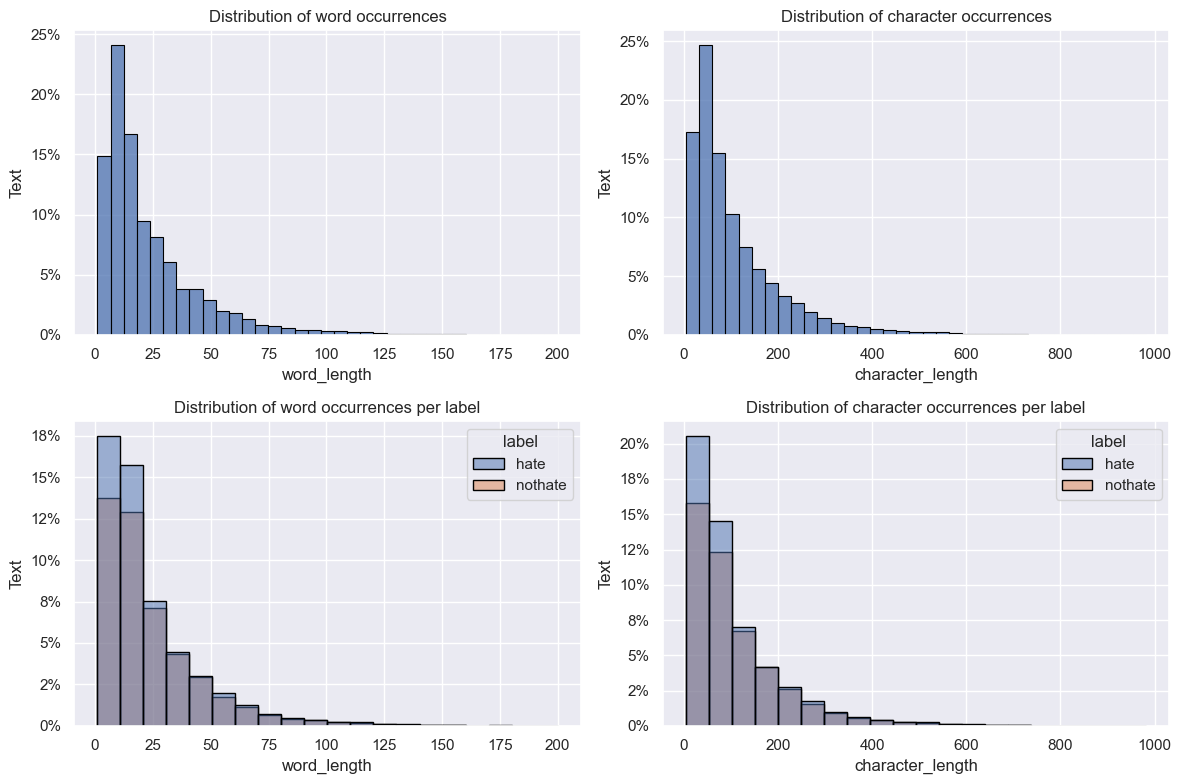

In [21]:
#Histplot of word and character occurrences 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
sns.histplot(data = new_df, x = 'word_length',ax = ax[0,0], weights=np.ones(len(new_df)) / len(new_df),  
             bins= 35,edgecolor='black')
sns.histplot(data = new_df, x = 'character_length', ax = ax[0,1], weights=np.ones(len(new_df)) / len(new_df),
             bins = 35,edgecolor='black')
sns.histplot(data = new_df, x = 'word_length', ax = ax[1,0], hue='label',weights=np.ones(len(new_df)) / len(new_df),
             bins= 20,edgecolor='black')
sns.histplot(data = new_df, x = 'character_length',ax = ax[1,1],  hue ='label', weights=np.ones(len(new_df)) / len(new_df),
             bins = 20,edgecolor='black')


ax[0,0].set_title('Distribution of word occurrences')
ax[0,1].set_title('Distribution of character occurrences')
ax[1,0].set_title('Distribution of word occurrences per label')
ax[1,1].set_title('Distribution of character occurrences per label')

all_axes = plt.gcf().get_axes()
for ax in all_axes:
    ax.set_ylabel('Text')
    ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
plt.tight_layout()
plt.show()

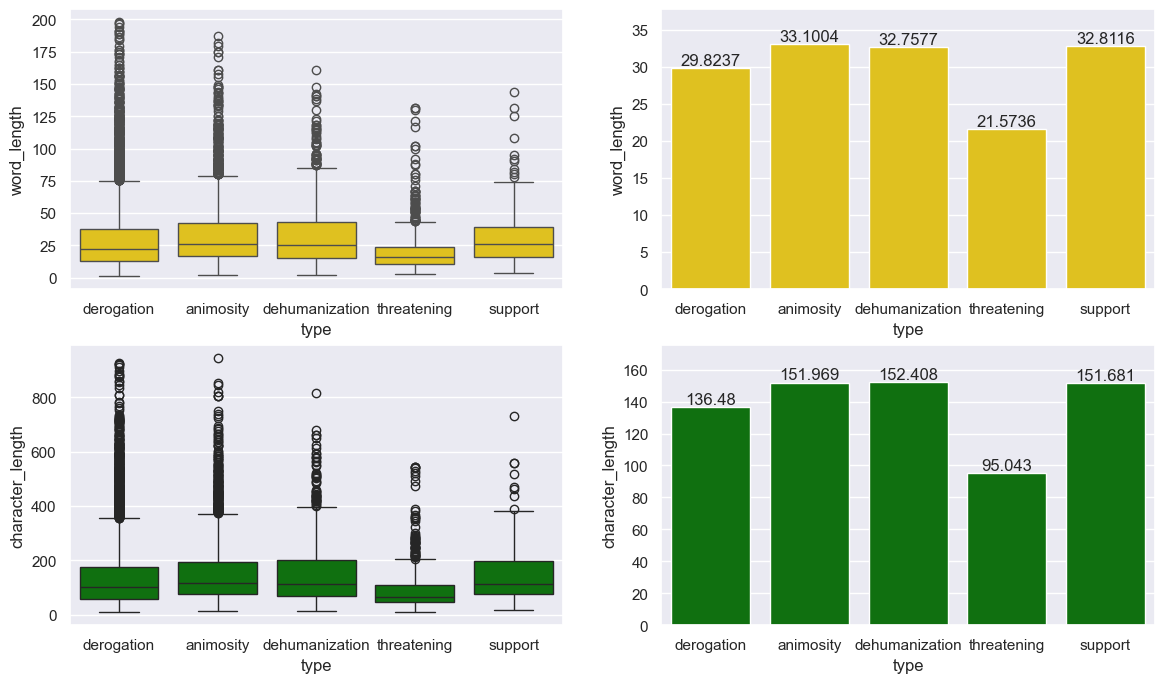

In [22]:
#Let's establish word and character distribution for hate types
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(14,8))
#Word
sns.boxplot(data=new_df[(new_df.label == 'hate') & (new_df.type != 'notgiven')], x ='type',y= 'word_length', ax = ax[0,0],color='gold')
sns.barplot(data=new_df[(new_df.label == 'hate') & (new_df.type != 'notgiven')],
                 x ='type',y= 'word_length',err_kws={'linewidth': 0}, 
                 color='gold',
                 ax = ax[0,1])
#Character
sns.boxplot(data=new_df[(new_df.label == 'hate') & (new_df.type != 'notgiven')], x ='type',y= 'character_length', ax = ax[1,0], color = 'green')
sns.barplot(data=new_df[(new_df.label == 'hate') & (new_df.type != 'notgiven')],
                 x ='type',y= 'character_length',err_kws={'linewidth': 0}, 
                 color='green',
                 ax = ax[1,1])
for i in ax[0,1].containers:
    ax[0,1].bar_label(i,)
for i in ax[1,1].containers:
    ax[1,1].bar_label(i,)


In [23]:
#We still denote some outliers for all types hate and a linear correlation between character and word observations
# Animosity and Dehumanization types seem to have the highest word and character length, and the threatening type the least one.

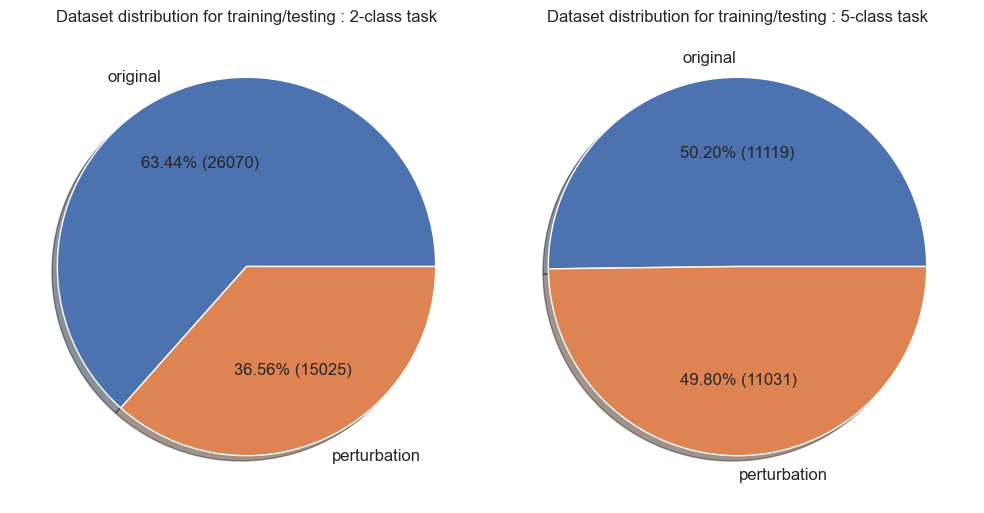

In [24]:
#Training and Testing dataset for 2-class and 6-class
sns.set_theme()
fig, (ax1,ax2)= plt.subplots(ncols=2,figsize=(14,4))
new_df.groupby('level').size().plot(kind = 'pie',
                                   autopct = lambda p: '{:.2f}% ({:.0f})'.format(p,(p/100)*len(new_df)),
                                   figsize = [10,10],
                                   textprops = {'fontsize': 12},
                                   shadow = True,
                                   startangle =0,
                                   ax = ax1)
new_df[(new_df['label']=='hate') & (new_df.type != 'notgiven')].groupby('level').size().plot(kind = 'pie',
                               autopct = lambda p :'{:.2f}% ({:.0f})'.format(p,(p/100)*len(new_df[new_df['label'] == 'hate'])),
                               figsize =[10,10],
                               textprops = {'fontsize': 12},
                               #explode=(0,0.1),
                               shadow= True,
                               startangle=0,
                               ax =ax2)
ax1.set_title('Dataset distribution for training/testing : 2-class task')
ax2.set_title('Dataset distribution for training/testing : 5-class task')
plt.tight_layout()
plt.show()

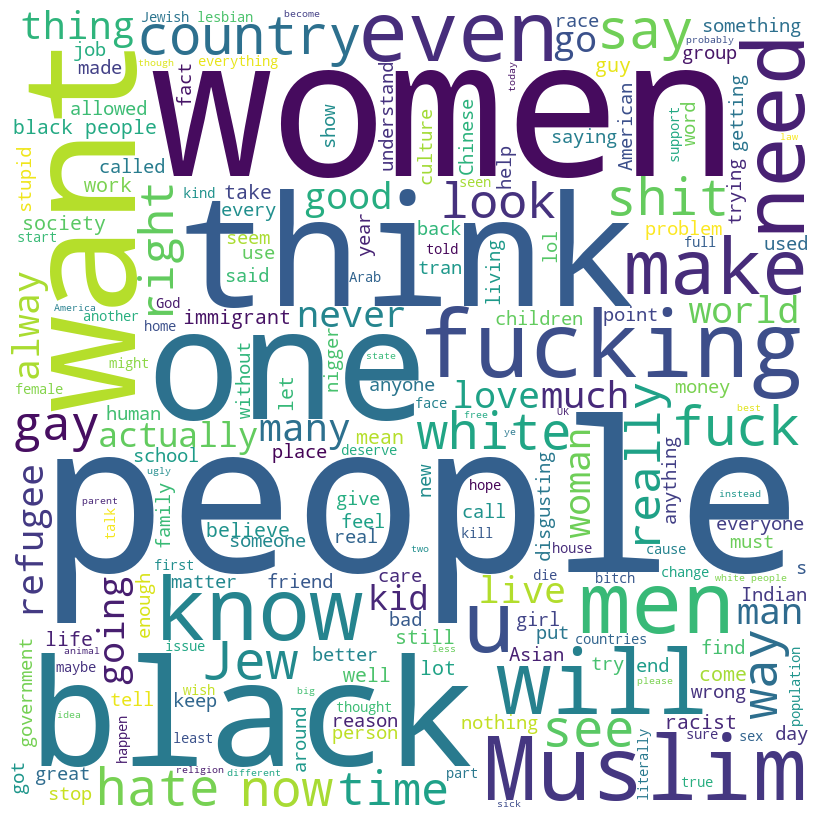

In [25]:
#Word cloud of dataset


# # Extract the text data
text = ' '.join(new_df.text)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=STOPWORDS,
                      min_font_size=10).generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<h1 align = center> DATA PRE-PROCESSING </h1>

In [26]:
%%time
# Lower case all the words before data preprocessing
df.text = df.text.str.lower()
# Short version terms
df.text = df.text.apply(lambda text: decontracted(text))
# Tokenization
tokenizer = TweetTokenizer()
df.text = df.text.apply(lambda text: tokenizer.tokenize(text))
# Stopwords removing
df.text = df.text.apply(lambda text: remove_stopwords(text))
#Replacing Emojis with their semantic equivalent
df.text = df.text.apply(lambda text: text_has_emoji(text))
# Punctuation removing
df.text = df.text.apply(lambda text: remove_punctuation(text))
# Lemmatization
df.text = df.text.apply(lambda text: lemmatize(text))

df.character_length = (df.text.str.len() - (df.text.str.split().str.len() - 1))
df.word_length = df.text.str.split().str.len()

CPU times: total: 28.3 s
Wall time: 55.7 s


In [27]:
df

,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched,character_length,word_length
0,acl1,1,dalits lowlives,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN,14,2
1,acl10,2,gay people burden society,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN,22,4
2,acl100,3,arab welcome,hate,notgiven,notgiven,original,train,1,vDe7GN0NrL,1,NaN,11,2
3,acl1000,4,say actually eliminate heebs wish naturally be...,hate,notgiven,notgiven,original,train,1,oemYWm1Tjg,1,NaN,51,8
4,acl10000,5,bananas black people,hate,notgiven,notgiven,original,test,1,QiOKkCi7F8,1,NaN,18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41139,acl9974,41228,indian culture backwards,hate,notgiven,notgiven,original,test,1,GNZuCtwed3,1,NaN,22,3
41140,acl11574,1752,woman want equality want charge,hate,derogation,wom,original,train,2,CAgNlUizNm,2a,acl11575,27,5
41141,acl13446,3832,fuck covid,nothate,none,none,original,train,2,CAgNlUizNm,2a,acl13447,9,2
41142,acl13457,3844,computer garbage,nothate,none,none,original,train,2,eLGzdD8Tvb,2a,acl13458,15,2


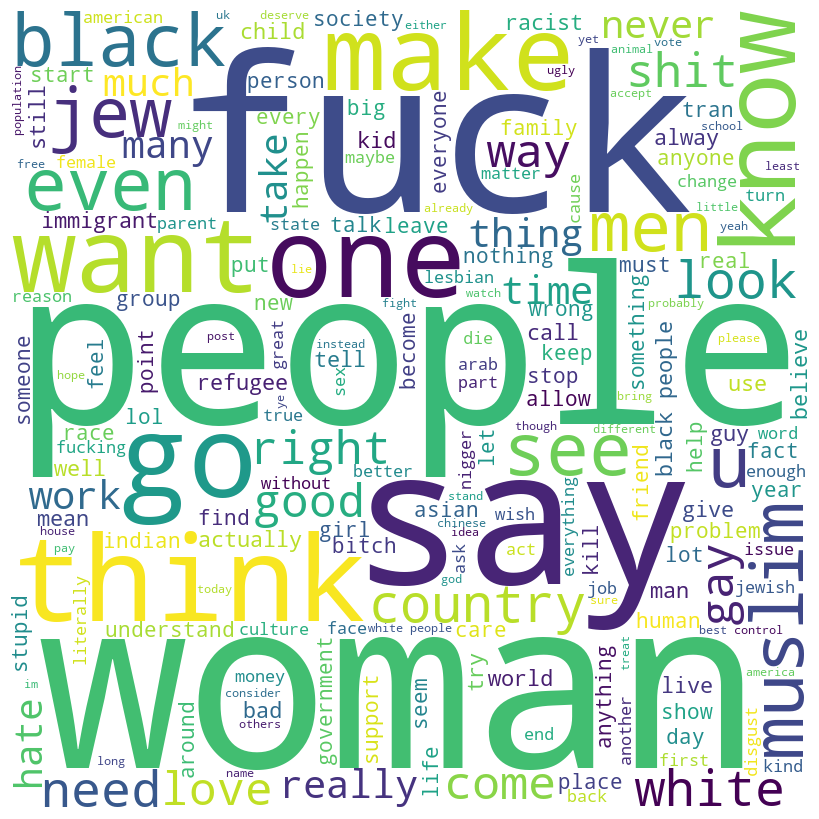

In [28]:
#Word cloud of dataset
# # Extract the text data
text = ' '.join(df.text)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=STOPWORDS,
                      min_font_size=10).generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<h1 align = center> BINARY CLASSIFICATION </h1>

<h2 align = center> BASELINE MODELS EVALUATION </h2>

<h2 align = center> SOTA MODELS EVALUATION </h2>

<h1 align = center>  MULTI-CLASSIFICATION </h1>

<h2 align = center> BASELINE MODELS EVALUATION </h2>

<h2 align = center> SOTA MODELS EVALUATION </h2>